<a href="https://colab.research.google.com/github/Matrixmax/Dive_into_DeepLearning/blob/main/0x23_%E5%A4%9A%E8%BE%93%E5%85%A5%E9%80%9A%E9%81%93%E5%92%8C%E5%A4%9A%E8%BE%93%E5%87%BA%E9%80%9A%E9%81%93.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

前面两节里我们用到的输入和输出都是二维数组，但真实数据的维度经常更高，如，彩色图像在高和宽2个维度外还有RGB（红、绿、蓝）3个颜色通道。假设彩色图像的高和宽分别是hh和ww（像素），那么它可以表示为一个3×h×w3×h×w的多维数组。**我们将大小为3的这一维称为通道（channel）维。**本节我们将介绍含多个输入通道或多个输出通道的卷积核。

## 1. 多输入通道
当输入数据包含多个通道时，我们需要构造一个输入通道数与输入数据的通道数相同的卷积核，从而能够与含多通道的输入数据做互相关运算。

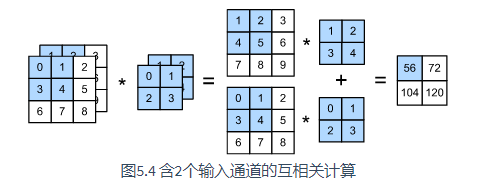

In [1]:
import collections
import math
import os
import random
import sys
import tarfile
import time
import json
import zipfile
from tqdm import tqdm
from PIL import Image
from collections import namedtuple

from IPython import display
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchtext
import torchtext.vocab as Vocab
import numpy as np


VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']


VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]



# ###################### 3.2 ############################
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

def use_svg_display():
    """Use svg format to display plot in jupyter"""
    display.set_matplotlib_formats('svg')

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j) 

def linreg(X, w, b):
    return torch.mm(X, w) + b

def squared_loss(y_hat, y): 
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return ((y_hat - y.view(y_hat.size())) ** 2) / 2

def sgd(params, lr, batch_size):
    # 为了和原书保持一致，这里除以了batch_size，但是应该是不用除的，因为一般用PyTorch计算loss时就默认已经
    # 沿batch维求了平均了。
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data



# ######################3##### 3.5 #############################
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_fashion_mnist(images, labels):
    use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    # plt.show()

# 5.6 修改
# def load_data_fashion_mnist(batch_size, root='~/Datasets/FashionMNIST'):
#     """Download the fashion mnist dataset and then load into memory."""
#     transform = transforms.ToTensor()
#     mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
#     mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)
#     if sys.platform.startswith('win'):
#         num_workers = 0  # 0表示不用额外的进程来加速读取数据
#     else:
#         num_workers = 4
#     train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
#     test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#     return train_iter, test_iter




# ########################### 3.6  ###############################
# (3.13节修改)
# def evaluate_accuracy(data_iter, net):
#     acc_sum, n = 0.0, 0
#     for X, y in data_iter:
#         acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
#         n += y.shape[0]
#     return acc_sum / n


def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step()  # “softmax回归的简洁实现”一节将用到
            
            
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))




# ########################### 3.7 #####################################3
class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)


# ########################### 3.11 ###############################
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    # plt.show()




# ############################# 3.13 ##############################
# 5.5 修改
# def evaluate_accuracy(data_iter, net):
#     acc_sum, n = 0.0, 0
#     for X, y in data_iter:
#         if isinstance(net, torch.nn.Module):
#             net.eval() # 评估模式, 这会关闭dropout
#             acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
#             net.train() # 改回训练模式
#         else: # 自定义的模型
#             if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
#                 # 将is_training设置成False
#                 acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
#             else:
#                 acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
#         n += y.shape[0]
#     return acc_sum / n






# ########################### 5.1 #########################
def corr2d(X, K):  
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y



# ############################ 5.5 #########################
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device 
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: # 自定义的模型, 3.13节之后不会用到, 不考虑GPU
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n

def train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    loss = torch.nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))



# ########################## 5.6 #########################3
def load_data_fashion_mnist(batch_size, resize=None, root='~/Datasets/FashionMNIST'):
    """Download the fashion mnist dataset and then load into memory."""
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    
    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)
    if sys.platform.startswith('win'):
        num_workers = 0  # 0表示不用额外的进程来加速读取数据
    else:
        num_workers = 4
    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_iter, test_iter



############################# 5.8 ##############################
class GlobalAvgPool2d(nn.Module):
    # 全局平均池化层可通过将池化窗口形状设置成输入的高和宽实现
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()
    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=x.size()[2:])



# ########################### 5.11 ################################
class Residual(nn.Module): 
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y + X)

def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
    if first_block:
        assert in_channels == out_channels # 第一个模块的通道数同输入通道数一致
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(in_channels, out_channels, use_1x1conv=True, stride=2))
        else:
            blk.append(Residual(out_channels, out_channels))
    return nn.Sequential(*blk)
    
def resnet18(output=10, in_channels=3):
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64), 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", GlobalAvgPool2d()) # GlobalAvgPool2d的输出: (Batch, 512, 1, 1)
    net.add_module("fc", nn.Sequential(FlattenLayer(), nn.Linear(512, output))) 
    return net



# ############################## 6.3 ##################################3
def load_data_jay_lyrics():
    """加载周杰伦歌词数据集"""
    with zipfile.ZipFile('../../data/jaychou_lyrics.txt.zip') as zin:
        with zin.open('jaychou_lyrics.txt') as f:
            corpus_chars = f.read().decode('utf-8')
    corpus_chars = corpus_chars.replace('\n', ' ').replace('\r', ' ')
    corpus_chars = corpus_chars[0:10000]
    idx_to_char = list(set(corpus_chars))
    char_to_idx = dict([(char, i) for i, char in enumerate(idx_to_char)])
    vocab_size = len(char_to_idx)
    corpus_indices = [char_to_idx[char] for char in corpus_chars]
    return corpus_indices, char_to_idx, idx_to_char, vocab_size

def data_iter_random(corpus_indices, batch_size, num_steps, device=None):
    # 减1是因为输出的索引x是相应输入的索引y加1
    num_examples = (len(corpus_indices) - 1) // num_steps
    epoch_size = num_examples // batch_size
    example_indices = list(range(num_examples))
    random.shuffle(example_indices)

    # 返回从pos开始的长为num_steps的序列
    def _data(pos):
        return corpus_indices[pos: pos + num_steps]
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for i in range(epoch_size):
        # 每次读取batch_size个随机样本
        i = i * batch_size
        batch_indices = example_indices[i: i + batch_size]
        X = [_data(j * num_steps) for j in batch_indices]
        Y = [_data(j * num_steps + 1) for j in batch_indices]
        yield torch.tensor(X, dtype=torch.float32, device=device), torch.tensor(Y, dtype=torch.float32, device=device)

def data_iter_consecutive(corpus_indices, batch_size, num_steps, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    corpus_indices = torch.tensor(corpus_indices, dtype=torch.float32, device=device)
    data_len = len(corpus_indices)
    batch_len = data_len // batch_size
    indices = corpus_indices[0: batch_size*batch_len].view(batch_size, batch_len)
    epoch_size = (batch_len - 1) // num_steps
    for i in range(epoch_size):
        i = i * num_steps
        X = indices[:, i: i + num_steps]
        Y = indices[:, i + 1: i + num_steps + 1]
        yield X, Y





# ###################################### 6.4 ######################################
def one_hot(x, n_class, dtype=torch.float32): 
    # X shape: (batch), output shape: (batch, n_class)
    x = x.long()
    res = torch.zeros(x.shape[0], n_class, dtype=dtype, device=x.device)
    res.scatter_(1, x.view(-1, 1), 1)
    return res

def to_onehot(X, n_class):  
    # X shape: (batch, seq_len), output: seq_len elements of (batch, n_class)
    return [one_hot(X[:, i], n_class) for i in range(X.shape[1])]

def predict_rnn(prefix, num_chars, rnn, params, init_rnn_state,
                num_hiddens, vocab_size, device, idx_to_char, char_to_idx):
    state = init_rnn_state(1, num_hiddens, device)
    output = [char_to_idx[prefix[0]]]
    for t in range(num_chars + len(prefix) - 1):
        # 将上一时间步的输出作为当前时间步的输入
        X = to_onehot(torch.tensor([[output[-1]]], device=device), vocab_size)
        # 计算输出和更新隐藏状态
        (Y, state) = rnn(X, state, params)
        # 下一个时间步的输入是prefix里的字符或者当前的最佳预测字符
        if t < len(prefix) - 1:
            output.append(char_to_idx[prefix[t + 1]])
        else:
            output.append(int(Y[0].argmax(dim=1).item()))
    return ''.join([idx_to_char[i] for i in output])

def grad_clipping(params, theta, device):
    norm = torch.tensor([0.0], device=device)
    for param in params:
        norm += (param.grad.data ** 2).sum()
    norm = norm.sqrt().item()
    if norm > theta:
        for param in params:
            param.grad.data *= (theta / norm)

def train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                          vocab_size, device, corpus_indices, idx_to_char,
                          char_to_idx, is_random_iter, num_epochs, num_steps,
                          lr, clipping_theta, batch_size, pred_period,
                          pred_len, prefixes):
    if is_random_iter:
        data_iter_fn = data_iter_random
    else:
        data_iter_fn = data_iter_consecutive
    params = get_params()
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        if not is_random_iter:  # 如使用相邻采样，在epoch开始时初始化隐藏状态
            state = init_rnn_state(batch_size, num_hiddens, device)
        l_sum, n, start = 0.0, 0, time.time()
        data_iter = data_iter_fn(corpus_indices, batch_size, num_steps, device)
        for X, Y in data_iter:
            if is_random_iter:  # 如使用随机采样，在每个小批量更新前初始化隐藏状态
                state = init_rnn_state(batch_size, num_hiddens, device)
            else: 
            # 否则需要使用detach函数从计算图分离隐藏状态, 这是为了
            # 使模型参数的梯度计算只依赖一次迭代读取的小批量序列(防止梯度计算开销太大)
                for s in state:
                    s.detach_()
            
            inputs = to_onehot(X, vocab_size)
            # outputs有num_steps个形状为(batch_size, vocab_size)的矩阵
            (outputs, state) = rnn(inputs, state, params)
            # 拼接之后形状为(num_steps * batch_size, vocab_size)
            outputs = torch.cat(outputs, dim=0)
            # Y的形状是(batch_size, num_steps)，转置后再变成长度为
            # batch * num_steps 的向量，这样跟输出的行一一对应
            y = torch.transpose(Y, 0, 1).contiguous().view(-1)
            # 使用交叉熵损失计算平均分类误差
            l = loss(outputs, y.long())
            
            # 梯度清0
            if params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            grad_clipping(params, clipping_theta, device)  # 裁剪梯度
            sgd(params, lr, 1)  # 因为误差已经取过均值，梯度不用再做平均
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]

        if (epoch + 1) % pred_period == 0:
            print('epoch %d, perplexity %f, time %.2f sec' % (
                epoch + 1, math.exp(l_sum / n), time.time() - start))
            for prefix in prefixes:
                print(' -', predict_rnn(prefix, pred_len, rnn, params, init_rnn_state,
                    num_hiddens, vocab_size, device, idx_to_char, char_to_idx))

                
                
                
# ################################### 6.5 ################################################
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size):
        super(RNNModel, self).__init__()
        self.rnn = rnn_layer
        self.hidden_size = rnn_layer.hidden_size * (2 if rnn_layer.bidirectional else 1) 
        self.vocab_size = vocab_size
        self.dense = nn.Linear(self.hidden_size, vocab_size)
        self.state = None

    def forward(self, inputs, state): # inputs: (batch, seq_len)
        # 获取one-hot向量表示
        X = to_onehot(inputs, self.vocab_size) # X是个list
        Y, self.state = self.rnn(torch.stack(X), state)
        # 全连接层会首先将Y的形状变成(num_steps * batch_size, num_hiddens)，它的输出
        # 形状为(num_steps * batch_size, vocab_size)
        output = self.dense(Y.view(-1, Y.shape[-1]))
        return output, self.state

def predict_rnn_pytorch(prefix, num_chars, model, vocab_size, device, idx_to_char,
                      char_to_idx):
    state = None
    output = [char_to_idx[prefix[0]]] # output会记录prefix加上输出
    for t in range(num_chars + len(prefix) - 1):
        X = torch.tensor([output[-1]], device=device).view(1, 1)
        if state is not None:
            if isinstance(state, tuple): # LSTM, state:(h, c)  
                state = (state[0].to(device), state[1].to(device))
            else:   
                state = state.to(device)
            
        (Y, state) = model(X, state)  # 前向计算不需要传入模型参数
        if t < len(prefix) - 1:
            output.append(char_to_idx[prefix[t + 1]])
        else:
            output.append(int(Y.argmax(dim=1).item()))
    return ''.join([idx_to_char[i] for i in output])

def train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    state = None
    for epoch in range(num_epochs):
        l_sum, n, start = 0.0, 0, time.time()
        data_iter = data_iter_consecutive(corpus_indices, batch_size, num_steps, device) # 相邻采样
        for X, Y in data_iter:
            if state is not None:
                # 使用detach函数从计算图分离隐藏状态, 这是为了
                # 使模型参数的梯度计算只依赖一次迭代读取的小批量序列(防止梯度计算开销太大)
                if isinstance (state, tuple): # LSTM, state:(h, c)  
                    state = (state[0].detach(), state[1].detach())
                else:   
                    state = state.detach()
    
            (output, state) = model(X, state) # output: 形状为(num_steps * batch_size, vocab_size)
            
            # Y的形状是(batch_size, num_steps)，转置后再变成长度为
            # batch * num_steps 的向量，这样跟输出的行一一对应
            y = torch.transpose(Y, 0, 1).contiguous().view(-1)
            l = loss(output, y.long())
            
            optimizer.zero_grad()
            l.backward()
            # 梯度裁剪
            grad_clipping(model.parameters(), clipping_theta, device)
            optimizer.step()
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]
        
        try:
            perplexity = math.exp(l_sum / n)
        except OverflowError:
            perplexity = float('inf')
        if (epoch + 1) % pred_period == 0:
            print('epoch %d, perplexity %f, time %.2f sec' % (
                epoch + 1, perplexity, time.time() - start))
            for prefix in prefixes:
                print(' -', predict_rnn_pytorch(
                    prefix, pred_len, model, vocab_size, device, idx_to_char,
                    char_to_idx))




# ######################################## 7.2 ###############################################
def train_2d(trainer):  
    x1, x2, s1, s2 = -5, -2, 0, 0  # s1和s2是自变量状态，本章后续几节会使用
    results = [(x1, x2)]
    for i in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

def show_trace_2d(f, results):  
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')




# ######################################## 7.3 ###############################################
def get_data_ch7():  
    data = np.genfromtxt('../../data/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
        torch.tensor(data[:1500, -1], dtype=torch.float32) # 前1500个样本(每个样本5个特征)

def train_ch7(optimizer_fn, states, hyperparams, features, labels,
              batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = linreg, squared_loss
    
    w = torch.nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32),
                           requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)

    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)
    
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y).mean()  # 使用平均损失
            
            # 梯度清零
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
                
            l.backward()
            optimizer_fn([w, b], states, hyperparams)  # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    set_figsize()
    plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    plt.xlabel('epoch')
    plt.ylabel('loss')

# 本函数与原书不同的是这里第一个参数优化器函数而不是优化器的名字
# 例如: optimizer_fn=torch.optim.SGD, optimizer_hyperparams={"lr": 0.05}
def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams, features, labels,
                    batch_size=10, num_epochs=2):
    # 初始化模型
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)

    def eval_loss():
        return loss(net(features).view(-1), labels).item() / 2

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            # 除以2是为了和train_ch7保持一致, 因为squared_loss中除了2
            l = loss(net(X).view(-1), y) / 2 
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    set_figsize()
    plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    plt.xlabel('epoch')
    plt.ylabel('loss')




############################## 8.3 ##################################
class Benchmark():
    def __init__(self, prefix=None):
        self.prefix = prefix + ' ' if prefix else ''

    def __enter__(self):
        self.start = time.time()

    def __exit__(self, *args):
        print('%stime: %.4f sec' % (self.prefix, time.time() - self.start))





# ########################### 9.1 ########################################
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y) 
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))




############################## 9.3 #####################
def bbox_to_rect(bbox, color):
    # 将边界框(左上x, 左上y, 右下x, 右下y)格式转换成matplotlib格式：
    # ((左上x, 左上y), 宽, 高)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)




############################ 9.4 ###########################
def MultiBoxPrior(feature_map, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5]):
    """
    # 按照「9.4.1. 生成多个锚框」所讲的实现, anchor表示成(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        feature_map: torch tensor, Shape: [N, C, H, W].
        sizes: List of sizes (0~1) of generated MultiBoxPriores. 
        ratios: List of aspect ratios (non-negative) of generated MultiBoxPriores. 
    Returns:
        anchors of shape (1, num_anchors, 4). 由于batch里每个都一样, 所以第一维为1
    """
    pairs = [] # pair of (size, sqrt(ration))
    for r in ratios:
        pairs.append([sizes[0], math.sqrt(r)])
    for s in sizes[1:]:
        pairs.append([s, math.sqrt(ratios[0])])
    
    pairs = np.array(pairs)
    
    ss1 = pairs[:, 0] * pairs[:, 1] # size * sqrt(ration)
    ss2 = pairs[:, 0] / pairs[:, 1] # size / sqrt(ration)
    
    base_anchors = np.stack([-ss1, -ss2, ss1, ss2], axis=1) / 2
    
    h, w = feature_map.shape[-2:]
    shifts_x = np.arange(0, w) / w
    shifts_y = np.arange(0, h) / h
    shift_x, shift_y = np.meshgrid(shifts_x, shifts_y)
    shift_x = shift_x.reshape(-1)
    shift_y = shift_y.reshape(-1)
    shifts = np.stack((shift_x, shift_y, shift_x, shift_y), axis=1)
    
    anchors = shifts.reshape((-1, 1, 4)) + base_anchors.reshape((1, -1, 4))
    
    return torch.tensor(anchors, dtype=torch.float32).view(1, -1, 4)

def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.detach().cpu().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=6, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

def compute_intersection(set_1, set_2):
    """
    计算anchor之间的交集
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)

def compute_jaccard(set_1, set_2):
    """
    计算anchor之间的Jaccard系数(IoU)
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    # Find intersections
    intersection = compute_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

def assign_anchor(bb, anchor, jaccard_threshold=0.5):
    """
    # 按照「9.4.1. 生成多个锚框」图9.3所讲为每个anchor分配真实的bb, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        bb: 真实边界框(bounding box), shape:（nb, 4）
        anchor: 待分配的anchor, shape:（na, 4）
        jaccard_threshold: 预先设定的阈值
    Returns:
        assigned_idx: shape: (na, ), 每个anchor分配的真实bb对应的索引, 若未分配任何bb则为-1
    """
    na = anchor.shape[0]
    nb = bb.shape[0]
    jaccard = compute_jaccard(anchor, bb).detach().cpu().numpy() # shape: (na, nb)
    assigned_idx = np.ones(na) * -1  # 初始全为-1
    
    # 先为每个bb分配一个anchor(不要求满足jaccard_threshold)
    jaccard_cp = jaccard.copy()
    for j in range(nb):
        i = np.argmax(jaccard_cp[:, j])
        assigned_idx[i] = j
        jaccard_cp[i, :] = float("-inf") # 赋值为负无穷, 相当于去掉这一行
     
    # 处理还未被分配的anchor, 要求满足jaccard_threshold
    for i in range(na):
        if assigned_idx[i] == -1:
            j = np.argmax(jaccard[i, :])
            if jaccard[i, j] >= jaccard_threshold:
                assigned_idx[i] = j
    
    return torch.tensor(assigned_idx, dtype=torch.long)

def xy_to_cxcy(xy):
    """
    将(x_min, y_min, x_max, y_max)形式的anchor转换成(center_x, center_y, w, h)形式的.
    https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py
    Args:
        xy: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    Returns: 
        bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h

def MultiBoxTarget(anchor, label):
    """
    # 按照「9.4.1. 生成多个锚框」所讲的实现, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        anchor: torch tensor, 输入的锚框, 一般是通过MultiBoxPrior生成, shape:（1，锚框总数，4）
        label: 真实标签, shape为(bn, 每张图片最多的真实锚框数, 5)
               第二维中，如果给定图片没有这么多锚框, 可以先用-1填充空白, 最后一维中的元素为[类别标签, 四个坐标值]
    Returns:
        列表, [bbox_offset, bbox_mask, cls_labels]
        bbox_offset: 每个锚框的标注偏移量，形状为(bn，锚框总数*4)
        bbox_mask: 形状同bbox_offset, 每个锚框的掩码, 一一对应上面的偏移量, 负类锚框(背景)对应的掩码均为0, 正类锚框的掩码均为1
        cls_labels: 每个锚框的标注类别, 其中0表示为背景, 形状为(bn，锚框总数)
    """
    assert len(anchor.shape) == 3 and len(label.shape) == 3
    bn = label.shape[0]
    
    def MultiBoxTarget_one(anc, lab, eps=1e-6):
        """
        MultiBoxTarget函数的辅助函数, 处理batch中的一个
        Args:
            anc: shape of (锚框总数, 4)
            lab: shape of (真实锚框数, 5), 5代表[类别标签, 四个坐标值]
            eps: 一个极小值, 防止log0
        Returns:
            offset: (锚框总数*4, )
            bbox_mask: (锚框总数*4, ), 0代表背景, 1代表非背景
            cls_labels: (锚框总数, 4), 0代表背景
        """
        an = anc.shape[0]
        assigned_idx = assign_anchor(lab[:, 1:], anc) # (锚框总数, )
        bbox_mask = ((assigned_idx >= 0).float().unsqueeze(-1)).repeat(1, 4) # (锚框总数, 4)

        cls_labels = torch.zeros(an, dtype=torch.long) # 0表示背景
        assigned_bb = torch.zeros((an, 4), dtype=torch.float32) # 所有anchor对应的bb坐标
        for i in range(an):
            bb_idx = assigned_idx[i]
            if bb_idx >= 0: # 即非背景
                cls_labels[i] = lab[bb_idx, 0].long().item() + 1 # 注意要加一
                assigned_bb[i, :] = lab[bb_idx, 1:]

        center_anc = xy_to_cxcy(anc) # (center_x, center_y, w, h)
        center_assigned_bb = xy_to_cxcy(assigned_bb)

        offset_xy = 10.0 * (center_assigned_bb[:, :2] - center_anc[:, :2]) / center_anc[:, 2:]
        offset_wh = 5.0 * torch.log(eps + center_assigned_bb[:, 2:] / center_anc[:, 2:])
        offset = torch.cat([offset_xy, offset_wh], dim = 1) * bbox_mask # (锚框总数, 4)

        return offset.view(-1), bbox_mask.view(-1), cls_labels
    
    batch_offset = []
    batch_mask = []
    batch_cls_labels = []
    for b in range(bn):
        offset, bbox_mask, cls_labels = MultiBoxTarget_one(anchor[0, :, :], label[b, :, :])
        
        batch_offset.append(offset)
        batch_mask.append(bbox_mask)
        batch_cls_labels.append(cls_labels)
    
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    cls_labels = torch.stack(batch_cls_labels)
    
    return [bbox_offset, bbox_mask, cls_labels]


Pred_BB_Info = namedtuple("Pred_BB_Info", ["index", "class_id", "confidence", "xyxy"])
def non_max_suppression(bb_info_list, nms_threshold = 0.5):
    """
    非极大抑制处理预测的边界框
    Args:
        bb_info_list: Pred_BB_Info的列表, 包含预测类别、置信度等信息
        nms_threshold: 阈值
    Returns:
        output: Pred_BB_Info的列表, 只保留过滤后的边界框信息
    """
    output = []
    # 先根据置信度从高到低排序
    sorted_bb_info_list = sorted(bb_info_list, key = lambda x: x.confidence, reverse=True)

    while len(sorted_bb_info_list) != 0:
        best = sorted_bb_info_list.pop(0)
        output.append(best)
        
        if len(sorted_bb_info_list) == 0:
            break

        bb_xyxy = []
        for bb in sorted_bb_info_list:
            bb_xyxy.append(bb.xyxy)
        
        iou = compute_jaccard(torch.tensor([best.xyxy]), 
                              torch.tensor(bb_xyxy))[0] # shape: (len(sorted_bb_info_list), )
        
        n = len(sorted_bb_info_list)
        sorted_bb_info_list = [sorted_bb_info_list[i] for i in range(n) if iou[i] <= nms_threshold]
    return output

def MultiBoxDetection(cls_prob, loc_pred, anchor, nms_threshold = 0.5):
    """
    # 按照「9.4.1. 生成多个锚框」所讲的实现, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        cls_prob: 经过softmax后得到的各个锚框的预测概率, shape:(bn, 预测总类别数+1, 锚框个数)
        loc_pred: 预测的各个锚框的偏移量, shape:(bn, 锚框个数*4)
        anchor: MultiBoxPrior输出的默认锚框, shape: (1, 锚框个数, 4)
        nms_threshold: 非极大抑制中的阈值
    Returns:
        所有锚框的信息, shape: (bn, 锚框个数, 6)
        每个锚框信息由[class_id, confidence, xmin, ymin, xmax, ymax]表示
        class_id=-1 表示背景或在非极大值抑制中被移除了
    """
    assert len(cls_prob.shape) == 3 and len(loc_pred.shape) == 2 and len(anchor.shape) == 3
    bn = cls_prob.shape[0]
    
    def MultiBoxDetection_one(c_p, l_p, anc, nms_threshold = 0.5):
        """
        MultiBoxDetection的辅助函数, 处理batch中的一个
        Args:
            c_p: (预测总类别数+1, 锚框个数)
            l_p: (锚框个数*4, )
            anc: (锚框个数, 4)
            nms_threshold: 非极大抑制中的阈值
        Return:
            output: (锚框个数, 6)
        """
        pred_bb_num = c_p.shape[1]
        anc = (anc + l_p.view(pred_bb_num, 4)).detach().cpu().numpy() # 加上偏移量
        
        confidence, class_id = torch.max(c_p, 0)
        confidence = confidence.detach().cpu().numpy()
        class_id = class_id.detach().cpu().numpy()
        
        pred_bb_info = [Pred_BB_Info(
                            index = i,
                            class_id = class_id[i] - 1, # 正类label从0开始
                            confidence = confidence[i],
                            xyxy=[*anc[i]]) # xyxy是个列表
                        for i in range(pred_bb_num)]
        
        # 正类的index
        obj_bb_idx = [bb.index for bb in non_max_suppression(pred_bb_info, nms_threshold)]
        
        output = []
        for bb in pred_bb_info:
            output.append([
                (bb.class_id if bb.index in obj_bb_idx else -1.0),
                bb.confidence,
                *bb.xyxy
            ])
            
        return torch.tensor(output) # shape: (锚框个数, 6)
    
    batch_output = []
    for b in range(bn):
        batch_output.append(MultiBoxDetection_one(cls_prob[b], loc_pred[b], anchor[0], nms_threshold))
    
    return torch.stack(batch_output)



# ################################# 9.6 ############################
class PikachuDetDataset(torch.utils.data.Dataset):
    """皮卡丘检测数据集类"""
    def __init__(self, data_dir, part, image_size=(256, 256)):
        assert part in ["train", "val"]
        self.image_size = image_size
        self.image_dir = os.path.join(data_dir, part, "images")
        
        with open(os.path.join(data_dir, part, "label.json")) as f:
            self.label = json.load(f)
            
        self.transform = torchvision.transforms.Compose([
            # 将 PIL 图片转换成位于[0.0, 1.0]的floatTensor, shape (C x H x W)
            torchvision.transforms.ToTensor()])
            
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, index):
        image_path = str(index + 1) + ".png"
        
        cls = self.label[image_path]["class"]
        label = np.array([cls] + self.label[image_path]["loc"], 
                         dtype="float32")[None, :]
        
        PIL_img = Image.open(os.path.join(self.image_dir, image_path)
                            ).convert('RGB').resize(self.image_size)
        img = self.transform(PIL_img)
        
        sample = {
            "label": label, # shape: (1, 5) [class, xmin, ymin, xmax, ymax]
            "image": img    # shape: (3, *image_size)
        }
        
        return sample

def load_data_pikachu(batch_size, edge_size=256, data_dir = '../../data/pikachu'):  
    """edge_size：输出图像的宽和高"""
    image_size = (edge_size, edge_size)
    train_dataset = PikachuDetDataset(data_dir, 'train', image_size)
    val_dataset = PikachuDetDataset(data_dir, 'val', image_size)
    

    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                             shuffle=True, num_workers=4)

    val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                           shuffle=False, num_workers=4)
    return train_iter, val_iter


# ################################# 9.9 #########################
def read_voc_images(root="../../data/VOCdevkit/VOC2012", 
                    is_train=True, max_num=None):
    txt_fname = '%s/ImageSets/Segmentation/%s' % (
        root, 'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    if max_num is not None:
        images = images[:min(max_num, len(images))]
    features, labels = [None] * len(images), [None] * len(images)
    for i, fname in tqdm(enumerate(images)):
        features[i] = Image.open('%s/JPEGImages/%s.jpg' % (root, fname)).convert("RGB")
        labels[i] = Image.open('%s/SegmentationClass/%s.png' % (root, fname)).convert("RGB")
    return features, labels # PIL image

# colormap2label = torch.zeros(256 ** 3, dtype=torch.uint8)
# for i, colormap in enumerate(VOC_COLORMAP):
#     colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
def voc_label_indices(colormap, colormap2label):
    """
    convert colormap (PIL image) to colormap2label (uint8 tensor).
    """
    colormap = np.array(colormap.convert("RGB")).astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

def voc_rand_crop(feature, label, height, width):
    """
    Random crop feature (PIL image) and label (PIL image).
    """
    i, j, h, w = torchvision.transforms.RandomCrop.get_params(
            feature, output_size=(height, width))
    
    feature = torchvision.transforms.functional.crop(feature, i, j, h, w)
    label = torchvision.transforms.functional.crop(label, i, j, h, w)    

    return feature, label

class VOCSegDataset(torch.utils.data.Dataset):
    def __init__(self, is_train, crop_size, voc_dir, colormap2label, max_num=None):
        """
        crop_size: (h, w)
        """
        self.rgb_mean = np.array([0.485, 0.456, 0.406])
        self.rgb_std = np.array([0.229, 0.224, 0.225])
        self.tsf = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=self.rgb_mean, 
                                             std=self.rgb_std)
        ])
        
        self.crop_size = crop_size # (h, w)
        features, labels = read_voc_images(root=voc_dir, 
                                           is_train=is_train, 
                                           max_num=max_num)
        self.features = self.filter(features) # PIL image
        self.labels = self.filter(labels)     # PIL image
        self.colormap2label = colormap2label
        print('read ' + str(len(self.features)) + ' valid examples')

    def filter(self, imgs):
        return [img for img in imgs if (
            img.size[1] >= self.crop_size[0] and
            img.size[0] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        
        return (self.tsf(feature),
                voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)



# ############################# 10.7 ##########################
def read_imdb(folder='train', data_root="/S1/CSCL/tangss/Datasets/aclImdb"): 
    data = []
    for label in ['pos', 'neg']:
        folder_name = os.path.join(data_root, folder, label)
        for file in tqdm(os.listdir(folder_name)):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '').lower()
                data.append([review, 1 if label == 'pos' else 0])
    random.shuffle(data)
    return data

def get_tokenized_imdb(data):
    """
    data: list of [string, label]
    """
    def tokenizer(text):
        return [tok.lower() for tok in text.split(' ')]
    return [tokenizer(review) for review, _ in data]

def get_vocab_imdb(data):
    tokenized_data = get_tokenized_imdb(data)
    counter = collections.Counter([tk for st in tokenized_data for tk in st])
    return torchtext.vocab.Vocab(counter, min_freq=5)

def preprocess_imdb(data, vocab):
    max_l = 500  # 将每条评论通过截断或者补0，使得长度变成500

    def pad(x):
        return x[:max_l] if len(x) > max_l else x + [0] * (max_l - len(x))

    tokenized_data = get_tokenized_imdb(data)
    features = torch.tensor([pad([vocab.stoi[word] for word in words]) for words in tokenized_data])
    labels = torch.tensor([score for _, score in data])
    return features, labels

def load_pretrained_embedding(words, pretrained_vocab):
    """从预训练好的vocab中提取出words对应的词向量"""
    embed = torch.zeros(len(words), pretrained_vocab.vectors[0].shape[0]) # 初始化为0
    oov_count = 0 # out of vocabulary
    for i, word in enumerate(words):
        try:
            idx = pretrained_vocab.stoi[word]
            embed[i, :] = pretrained_vocab.vectors[idx]
        except KeyError:
            oov_count += 1
    if oov_count > 0:
        print("There are %d oov words." % oov_count)
    return embed

def predict_sentiment(net, vocab, sentence):
    """sentence是词语的列表"""
    device = list(net.parameters())[0].device
    sentence = torch.tensor([vocab.stoi[word] for word in sentence], device=device)
    label = torch.argmax(net(sentence.view((1, -1))), dim=1)
    return 'positive' if label.item() == 1 else 'negative'

In [4]:
def corr2d_multi_in(X, K):
    # 沿着X和K的第0维（通道维）分别计算再相加
    res = corr2d(X[0, :, :], K[0, :, :])
    for i in range(1, X.shape[0]):
        res += corr2d(X[i, :, :], K[i, :, :])
    return res

In [5]:
# 构造一个图5.4中的输入数组X，核数组K来验证互相关运算的输出
X = torch.tensor([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
              [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
K = torch.tensor([[[0, 1], [2, 3]], [[1, 2], [3, 4]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

## 2. 多输出通道
**当输入通道有多个时，因为我们对各个通道的结果做了累加，所以不论输入通道数是多少，输出通道数总是为1**。设卷积核输入通道数和输出通道数分别为$c_{i}$和$c_{0}$，高和宽分别为$k_{h}$和$k_{w}$。**如果希望得到含多个通道的输出，我们可以为每个输出通道分别创建形状为$c_{i} \times k_{h} \times k_w$的核数组。将它们在输出通道维上连结，卷积核的形状即$c_{0} \times c_{i} \times k_{h} \times k_w$。**

**在做互相关运算时，每个输出通道上的结果由卷积核在该输出通道上的核数组与整个输入数组计算而来**。

下面我们实现一个互相关运算函数来计算多个通道的输出。

In [6]:
def corr2d_multi_in_out(X, K):
    # 对K的第0维遍历，每次同输入X做互相关计算。所有结果使用stack函数合并在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K])


In [7]:
# 我们将K同K+1（K中每个元素加一）和K+2连结在一起来构造一个输出通道数为3的卷积核。
K = torch.stack([K,K+1,K+2])
K.shape  # torch.Size([3, 2, 2, 2])

torch.Size([3, 2, 2, 2])

In [8]:
# 下面我们对输入数组X与核数组K做互相关运算。此时的输出含有3个通道。其中第一个通道的结果与之前输入数组X与多输入通道、单输出通道核的计算结果一致。
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

## 3. 1X1卷积层

最后我们讨论卷积窗口形状为1×1的多通道卷积层。我们通常称之为1×1卷积层，并将其中的卷积运算称为1×1卷积。因为使用了最小窗口，1×11×1卷积失去了卷积层可以识别高和宽维度上相邻元素构成的模式的功能。实际上，1×1卷积的主要计算发生在通道维上。图5.5展示了使用输入通道数为3、输出通道数为2的1×1卷积核的互相关计算。值得注意的是，输入和输出具有相同的高和宽。输出中的每个元素来自输入中在高和宽上相同位置的元素在不同通道之间的按权重累加。**假设我们将通道维当作特征维，将高和宽维度上的元素当成数据样本，那么1×1卷积层的作用与全连接层等价。**


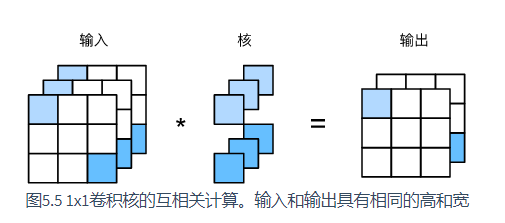

In [14]:
def corr2d_multi_in_out_1x1(X,K):
    c_i,h,w = X.shape
    c_o = K.shape[0]
    X = X.view(c_i,h*w)
    K = K.view(c_o,c_i)
    Y = torch.mm(K, X)  # 全连接层的矩阵乘法
    return Y.view(c_o, h, w)

In [15]:
#经验证，做1×11×1卷积时，以上函数与之前实现的互相关运算函数corr2d_multi_in_out等价。
X = torch.rand(3, 3, 3)
K = torch.rand(2, 3, 1, 1)

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)

(Y1 - Y2).norm().item() < 1e-6

True

在之后的模型里我们将会看到1×11×1卷积层被当作保持高和宽维度形状不变的全连接层使用。于是，我们可以通过调整网络层之间的通道数来控制模型复杂度。